# Overview:

Done:

* Able to get the neuron_output
* Training

To-do:

* for AlexNet, the filter size, stridel, padding size change across different layers --> need to address this?
* pre-trained = True --> is this correct? 
* check if *list method is correct 

References:

https://deeplearning.neuromatch.io/projects/Neuroscience/blurry_vision.html?highlight=alexnet

https://www.kaggle.com/asilvaigor/learning-alexnet

https://www.kaggle.com/drvaibhavkumar/alexnet-in-pytorch-cifar10-clas-83-test-accuracy

https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3?u=klory

https://distill.pub/2017/feature-visualization/

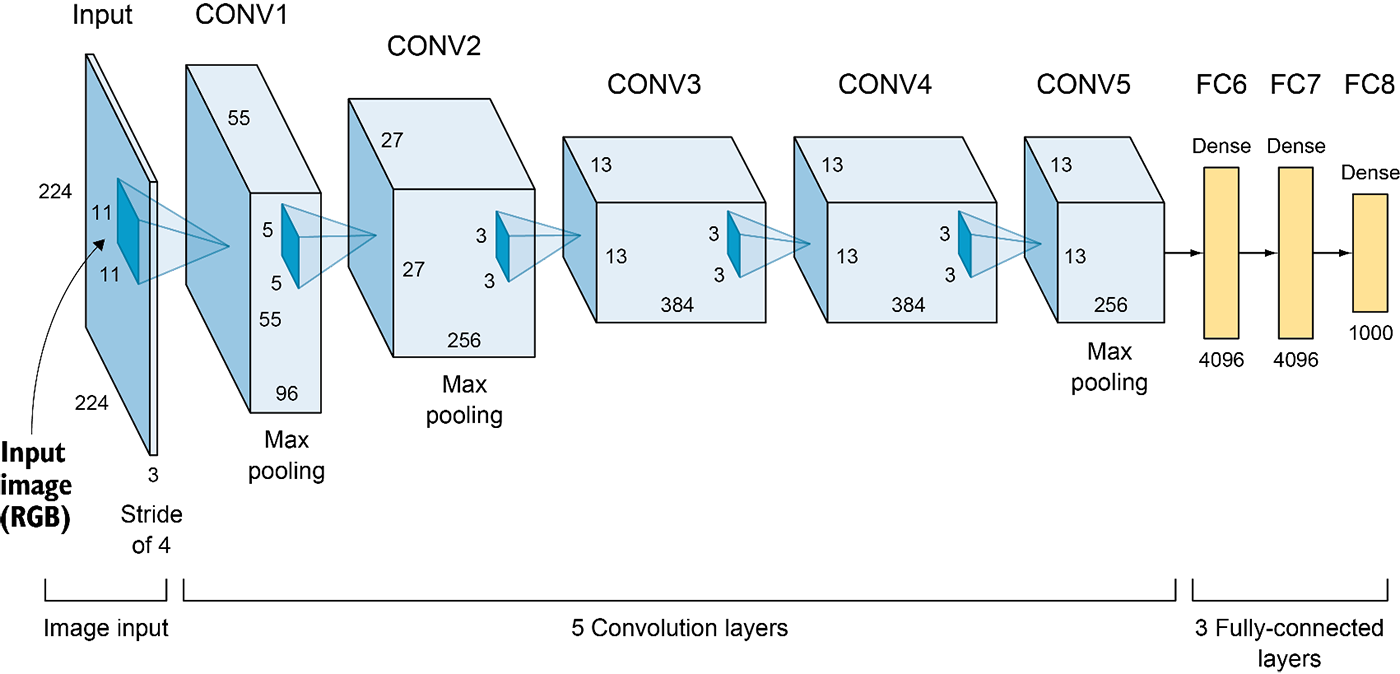

In [1]:
import tensorflow as tf
import numpy as np
import pathlib
import datetime

# printout versions
print(f"Tensor Flow Version: {tf.__version__}")
print(f"numpy Version: {np.version.version}")

Tensor Flow Version: 2.5.0
numpy Version: 1.21.2


In [2]:
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import InputLayer, Input
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.python.keras import backend as K
import math

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision.datasets import CIFAR10
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import torch.optim as optim
import time

C:\Users\ifisa\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [4]:
print(torch.__version__)

1.8.0+cpu


In [5]:
print(torchvision.__version__)

0.11.2+cpu


# Loading CIFAR-10 data:

In [6]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
train_data = CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)

test_data = CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)

classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_data[1][0]

tensor([[[ 0.1083,  0.0569,  0.0056,  ..., -0.6794, -0.7137, -0.7479],
         [ 0.0912,  0.0398, -0.0116,  ..., -0.7137, -0.7479, -0.7822],
         [ 0.0741,  0.0227, -0.0287,  ..., -0.7479, -0.7650, -0.7993],
         ...,
         [ 0.5536,  0.5536,  0.5364,  ..., -1.1418, -1.1075, -1.0562],
         [ 0.5536,  0.5536,  0.5364,  ..., -1.0048, -0.9705, -0.9363],
         [ 0.5536,  0.5536,  0.5536,  ..., -0.8678, -0.8335, -0.7993]],

        [[ 0.2927,  0.2227,  0.1527,  ..., -0.5126, -0.5476, -0.5826],
         [ 0.2752,  0.2052,  0.1352,  ..., -0.5476, -0.5826, -0.6176],
         [ 0.2577,  0.1877,  0.1176,  ..., -0.5826, -0.6176, -0.6352],
         ...,
         [ 0.7129,  0.7304,  0.7479,  ..., -1.1779, -1.1429, -1.1078],
         [ 0.7129,  0.7304,  0.7479,  ..., -1.0553, -1.0028, -0.9678],
         [ 0.7129,  0.7304,  0.7479,  ..., -0.9153, -0.8803, -0.8452]],

        [[ 0.4788,  0.3916,  0.3219,  ..., -0.6193, -0.6541, -0.6715],
         [ 0.4614,  0.3916,  0.3045,  ..., -0

In [9]:
N_train = 50000
N_test = 10000
img_shape = (3, 32, 32) #use a tuple in the fomat: (n_channels, height, width)
n_classes = 10
print(N_train,N_test,img_shape,n_classes)

50000 10000 (3, 32, 32) 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


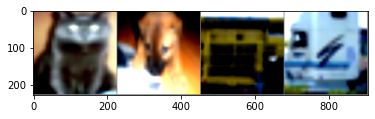

  Cat   Dog Truck Truck


In [10]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
im = images[0]

In [12]:

im.shape

torch.Size([3, 224, 224])

In [13]:
imshift = np.roll(im, shift = 10, axis=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


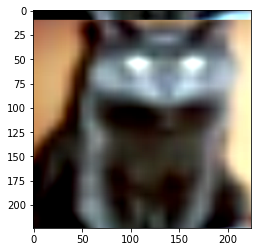

In [14]:
imshow(torch.tensor(imshift))

In [15]:
imshift = np.roll(im, shift = 10, axis=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


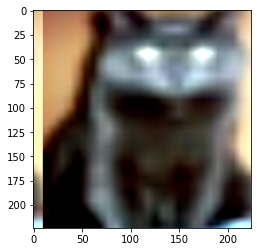

In [16]:
imshow(torch.tensor(imshift))

# Training AlexNet:

In [17]:
# Define AlexNet with different modules representing different brain areas
class AlexNet(nn.Module):

  def __init__(self, num_classes=1000, downscale=1):
    """
    Args:
      num_classes: int
      downscale: int
    """
    super(AlexNet, self).__init__()
    self.conv_layer1 = nn.Sequential(
        nn.Conv2d(3, 64//downscale, kernel_size=11, stride=4, padding=2),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(64//downscale),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.conv_layer2 = nn.Sequential(
        nn.Conv2d(64//downscale, 192//downscale, kernel_size=5, padding=2),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(192//downscale),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.conv_layer3 = nn.Sequential(
        nn.Conv2d(192//downscale, 384//downscale, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384//downscale),
    )
    self.conv_layer4 = nn.Sequential(
        nn.Conv2d(384//downscale, 256//downscale, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256//downscale),
    )
    self.conv_layer5 = nn.Sequential(
        nn.Conv2d(256//downscale, 256//downscale, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256//downscale),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
    self.it = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256//downscale * 6 * 6, 4096//downscale),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096//downscale, 4096//downscale),
        nn.ReLU(inplace=True)
    )
    self.classifier = nn.Linear(4096//downscale, num_classes)

  def forward(self, x):
    """
    Args:
      x: torch.Tensor
    Returns:
      x: torch.Tensor
    """
    x = self.conv_layer1(x)
    x = self.conv_layer2(x)
    x = self.conv_layer3(x)
    x = self.conv_layer4(x)
    x = self.conv_layer5(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.it(x)
    x = self.classifier(x)
    return x

In [18]:
AlexNet_Model = AlexNet(num_classes=10, downscale=2)
AlexNet_Model.eval()

AlexNet(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(32, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer4): Sequential(
    (0): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Ba

In [19]:
# AlexNet_Model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

In [20]:
# import torch.nn as nn
# AlexNet_Model.classifier[1] = nn.Linear(9216,4096)
# AlexNet_Model.classifier[4] = nn.Linear(4096,1024)
# AlexNet_Model.classifier[6] = nn.Linear(1024,10)

In [21]:
# class AlexNet(nn.Module):
#     def __init__(self, num_classes=1000):
#         super(AlexNet, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, 11, stride=4),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(3, stride=2),
#             nn.Conv2d(64, 192, 5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(3, stride=2),
#             nn.Conv2d(192, 384, 3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, 3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, 3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(3, stride=2),
#         )
#         self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
#         self.classifier = nn.Sequential(
#             nn.Dropout(),
#             nn.Linear(256 * 6 * 6, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, num_classes),
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         return x
# from torch.utils import model_zoo
# def alexnet_classifier(num_classes):
#     classifier = nn.Sequential(
#             nn.Dropout(p=0.5, inplace=False),
#             nn.Linear(9216,4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5, inplace=False),
#             nn.Linear(4096,1024),
#             nn.ReLU(inplace=True),
#             nn.Linear(1024,num_classes),
#             nn.Softmax(),
#         )
#     return classifier

# def alexnet(num_classes, pretrained=False, **kwargs):
#     """AlexNet model architecture from the
#     `"One weird trick..." `_ paper.
#     Args:
#         pretrained (bool): If True, returns a model pre-trained on ImageNet
#     """
#     model = AlexNet(**kwargs)
#     if pretrained:
#         model.load_state_dict(model_zoo.load_url('https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth'))
#         for p in model.features.parameters():
#             p.requires_grad=False
#     classifier = alexnet_classifier(num_classes)
#     model.classifier = classifier
#     return model
# model = alexnet(10, True)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(AlexNet_Model.parameters(), lr=0.001, momentum=0.9)

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
print(device)

cpu


In [25]:
AlexNet_Model.to(device)

AlexNet(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(32, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer4): Sequential(
    (0): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Ba

# Epoch 1:

In [26]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_Model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            print('Time:',time_taken)
            running_loss = 0.0

print('Finished Training of AlexNet: Epoch 1')

[1,  2000] loss: 2.206
Time: 161.55840635299683
[1,  4000] loss: 1.842
Time: 316.2691898345947
[1,  6000] loss: 1.626
Time: 475.1041843891144
[1,  8000] loss: 1.490
Time: 637.4448511600494
[1, 10000] loss: 1.377
Time: 797.2660157680511
[1, 12000] loss: 1.265
Time: 958.4150490760803
Finished Training of AlexNet: Epoch 1


# Get accuracy:

In [27]:
# define function to calculate current accuracy with a given dataloader
def accuracy(dataloader, device='cpu'): #Get the accuracies
  net.eval()
  correct = 0
  count = 0
  for data, target in tqdm.tqdm(dataloader):
    data = data.to(device).float()
    target = target.to(device).long()

    prediction = net(data)
    _, predicted = torch.max(prediction, 1)
    count += target.size(0)
    correct += (predicted == target).sum().item()

  acc = 100 * correct / count
  return count, acc


# define function to evaluate and print training and test accuracy
def evaluate(net, device='cpu', title=""):
  net.eval()
  train_count, train_acc = accuracy(clear_train_batches, device=device)
  test_count, test_acc = accuracy(clear_test_batches, device=device)
  print(f'Accuracy on the {train_count} clear training samples {title}: {train_acc:0.2f}')
  print(f'Accuracy on the {test_count} clear testing samples {title}: {test_acc:0.2f}')
  train_count, train_acc = accuracy(noisy_train_batches, device=device)
  test_count, test_acc = accuracy(noisy_test_batches, device=device)
  print(f'Accuracy on the {train_count} blurry training samples {title}: {train_acc:0.2f}')
  print(f'Accuracy on the {test_count} blurry testing samples {title}: {test_acc:0.2f}')

# Visualizing filters:

In [28]:
def show_weights(layer, i=0):
    filter = layer[0].weight.cpu().data
    filter = (1 / (2 * filter.max())) * filter + 0.5 #Normalizing the values to [0,1]
    print(filter.shape)
    img = torchvision.utils.make_grid(filter)
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    imshow(img)

torch.Size([32, 3, 11, 11])
(54, 106, 3)


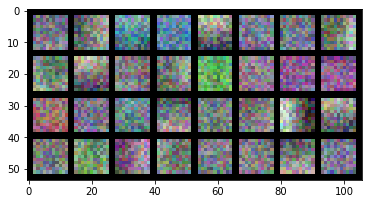

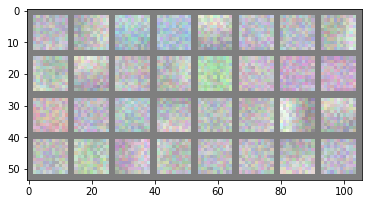

In [29]:
show_weights(AlexNet_Model.conv_layer1)

# Visualizing outputs given an image: 

In [30]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


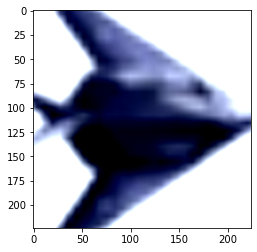

In [31]:
imshow(images[0])

In [32]:
images = images.type(torch.cuda.FloatTensor)
im = images[0].unsqueeze(0)

RuntimeError: Cannot initialize CUDA without ATen_cuda library. PyTorch splits its backend into two shared libraries: a CPU library and a CUDA library; this error has occurred because you are trying to use some CUDA functionality, but the CUDA library has not been loaded by the dynamic linker for some reason.  The CUDA library MUST be loaded, EVEN IF you don't directly use any symbols from the CUDA library! One common culprit is a lack of -INCLUDE:?warp_size@cuda@at@@YAHXZ in your link arguments; many dynamic linkers will delete dynamic library dependencies if you don't depend on any of their symbols.  You can check if this has occurred by using link on your binary to see if there is a dependency on *_cuda.dll library.

In [ ]:
im.shape

In [ ]:
# def plot_intermediate_layers(image, net, return_layers):
#   # Get output for the image from the intermediate layers
#   intermediate_output = LayerGetter(net, return_layers=return_layers)(image)
#   fig = plt.figure(figsize=(12, 3))
#   ax=fig.add_subplot(141)
#   ax.imshow(image.squeeze(0).permute(1, 2, 0))
#   plt.axis('off')
#   plt.title('Original Image')
#   ax=fig.add_subplot(142)
#   ax.imshow(intermediate_output[0]['v1'].detach().cpu().squeeze(0).mean(axis=0))
#   plt.axis('off')
#   plt.title('V1 layer (Average)')
#   ax=fig.add_subplot(143)
#   ax.imshow(intermediate_output[0]['v2'].detach().cpu().squeeze(0).mean(axis=0))
#   plt.axis('off')
#   plt.title('V2 layer (Average)')
#   ax=fig.add_subplot(144)
#   ax.imshow(intermediate_output[0]['v4'].detach().cpu().squeeze(0).mean(axis=0))
#   plt.axis('off')
#   plt.title('V4 layer (Average)')
#   plt.show()

In [ ]:
!pip install torch_intermediate_layer_getter

In [ ]:
from torch_intermediate_layer_getter import IntermediateLayerGetter as LayerGetter
return_layers = {
    # "<name of layer in the AlexNet Class>" : "<key for the layer output in the returned dictionary>"
      'conv_layer1': 'conv_layer1',
      'conv_layer3': 'conv_layer3',
      'conv_layer5': 'conv_layer5',
  }
net = AlexNet_Model
LayerGetter = torchvision.models._utils.IntermediateLayerGetter(net, return_layers=return_layers)
intermediate_output = LayerGetter(im)
print(intermediate_output['conv_layer3'].shape)

In [ ]:
fig, axs = plt.subplots(5, 5, figsize = (10,10))
for i , ax in enumerate(axs.flatten()):    
    ax.imshow(intermediate_output['conv_layer1'][0,i,:,:].cpu().data)
fig.suptitle('Visualizing Outputs for first 25 filters in conv_layer1', fontsize=20)

In [ ]:
fig, axs = plt.subplots(5, 5, figsize = (10,10))
for i , ax in enumerate(axs.flatten()):    
    ax.imshow(intermediate_output['conv_layer3'][0,i,:,:].cpu().data)
fig.suptitle('Visualizing Outputs for first 25 filters in conv_layer3', fontsize=20)

In [ ]:
fig, axs = plt.subplots(5, 5, figsize = (10,10))
for i , ax in enumerate(axs.flatten()):    
    ax.imshow(intermediate_output['conv_layer5'][0,i,:,:].cpu().data)
fig.suptitle('Visualizing Outputs for first 25 filters in conv_layer5', fontsize=20)

In [ ]:
f = torch.nn.Sequential(*list(AlexNet_Model.children())[:-23])
feature_outputs = f(im)

In [ ]:
plt.imshow(feature_outputs[0,0,:,:].cpu().data)

In [ ]:
f = torch.nn.Sequential(*list(AlexNet_Model.children())[:-15])
feature_outputs = f(im)

In [ ]:
plt.imshow(feature_outputs[0,0,:,:].cpu().data)

# Visualizing embeddings:

In [ ]:
AlexNet_Model.children()

In [ ]:
def apply_all_shifts(im, shift_step):
    '''
    arg(s): 
        DEBUG NOTE: PYTORCH IS (#channels, rows, cols)!!
        im, an image of shape (3, im_size, im_size)
    return: 
        im_all_shifts, a list of all shifted images from the input image
        n_shifts, number of shifted images
    '''
    
    ## vertical size might not be the same as the horizontal
    im_size_vertical = im.shape[1]
    im_size_horizontal = im.shape[2]
    
    n_shifts_vertical = int(math.ceil(im_size_vertical/ shift_step))
    n_shifts_horizontal = int(math.ceil(im_size_horizontal/ shift_step))
    
    im_all_shifts = []
    im_shift = im
    for i in range(n_shifts_vertical):
        im_shift = np.roll(im_shift, shift = shift_step * i, axis=1)
        
        for j in range(n_shifts_horizontal):
            im_shift = np.roll(im_shift, shift = shift_step * j, axis=2)
            im_all_shifts.append(im_shift)
            
    im_all_shifts =  np.array(im_all_shifts)
    return im_all_shifts, n_shifts_vertical * n_shifts_horizontal

In [ ]:
def compute_neuron_output_alt(layer_names, images, plot_activity = False):

    '''
    arg(s):
        layer_names: list of strings indicating the names of the layers we want to take neuron outputs from
        images: an array of images (stimuli)
    return:
        
    '''
    n_images = images.shape[0]
    n_layers = len(layer_names)
    neuron_output_highest = []
    all_fm_avg = []
    neuron_labels = []
    images = images.type(torch.cuda.FloatTensor)
    
    layer_index = 1
    for layer_name in layer_names:
        ## note: always take the images as inputs
        return_layers = {layer_name: layer_name}
        LayerGetter = torchvision.models._utils.IntermediateLayerGetter(AlexNet_Model, return_layers=return_layers)
        neuron_output = []
        for i in range(n_images):
          im = images[i]
          im = torch.reshape(im, (1, im.shape[0],im.shape[1],im.shape[2]))
          output = LayerGetter(im)
          output = output[layer_name] 
          neuron_output.append(output)
        neuron_output =  torch.stack(neuron_output)
        neuron_output = neuron_output.reshape((neuron_output.shape[0], neuron_output.shape[2], neuron_output.shape[3], neuron_output.shape[4]))

        neuron_output = neuron_output.permute(0, 2, 3, 1)
        
        ## number of neurons is nrow * ncol * n_feature_maps
        n_images, n_row, n_col, n_feature_maps = neuron_output.shape[:]
        
        ## remove the neurons at the edges
        neuron_output = neuron_output[:,2:(n_row-2),2:(n_col-2),:]
        n_images, n_row, n_col, n_feature_maps = neuron_output.shape[:]
        neuron_output = neuron_output.reshape((n_images, n_row * n_col, n_feature_maps))
        n_neurons = n_row * n_col
        
        # neuron_index = np.empty((n_row,n_col),dtype=int)
        # index = 0
        # for i in range(n_row):
        #     for j in range(n_col):
        #         neuron_index[i, j] = index
        #         index += 1
                
        # ## obtain the index of the neurons at the edges
        # neuron_edge_index = np.hstack((neuron_index[[0,1,n_row-2,n_row-1],:].reshape((4*32,1)), neuron_index[:,[0,1,n_col-2,n_col-1]].reshape((4*32,1))))
        # neuron_edge_index = neuron_edge_index.reshape((256,1))
        

        # ## re-label the neurons at the edge with a different color
        # neuron_labels = []
        # for i in range(10):    
        #     neuron_labels = np.hstack((neuron_labels, [i] * n_neurons))
        #     neuron_labels = np.array(neuron_labels)
        #     neuron_labels[n_neurons * i + neuron_edge_index-1] = 15
        
        # neuron_output = neuron_output.reshape((n_images, n_neurons, n_feature_maps))
        
        ## transpose to organize by feature maps
        ## neuron_output_by_fm is (n_images, n_feature_maps, #neurons)
        neuron_output_by_fm = neuron_output.permute(0, 2, 1)
        
        ## compute avg neuron firing rate in each feature map
        ## fm_avg is (n_images, n_feature_maps)
        fm_avg = neuron_output_by_fm.sum(axis=2) / neuron_output_by_fm.shape[2]
        
        if layer_index == 1: 
            fm_avg_all_layers = fm_avg
            neuron_output_by_fm_all_layers = neuron_output_by_fm
        else:
            fm_avg_all_layers = np.hstack((fm_avg_all_layers, fm_avg))
            neuron_output_by_fm_all_layers = np.concatenate((neuron_output_by_fm_all_layers,neuron_output_by_fm), axis = 1)

    neuron_output_highest = np.empty((n_images,n_neurons *10))
    fm_avg_all_layers = fm_avg_all_layers.cpu().data
    neuron_output_by_fm_all_layers = neuron_output_by_fm_all_layers.cpu().data
    
    for i in range(n_images):
        max10_indices = np.argpartition(fm_avg_all_layers[i], -10, axis = 0)[-10:]
        neuron_output_highest[i] = neuron_output_by_fm_all_layers[i, max10_indices, :].reshape((1,n_neurons *10))

    for i in range(10):    
        neuron_labels += [i] * n_neurons

    neuron_labels = np.array(neuron_labels)  


    return neuron_output_highest, fm_avg_all_layers, neuron_labels 

In [ ]:
def show_stimuli(layer_names, images_selected_classes, shifts, plot_activity = False):
    '''
    arg(s): 
        layer_indices, interested layers
        images_selected_classes, all the selected images
        shifts = True/False
    return:
        neuron_output_shifts_avg, (n_images, n_neurons)
    '''
    
    # images_selected_classes = np.array(images_selected_classes)
    n_images_selected_classes = 40

    if shifts is False:
        neuron_output_highest, fm_avg_all_layers, neuron_labels = compute_neuron_output_alt(layer_names, images_selected_classes, plot_activity = plot_activity)
  
    else: 
        # generate shifts for each selected image: 
        neuron_output_highest_with_shifts = []
        fm_avg_all_layers_with_shifts = []
        for i in range(n_images_selected_classes):
            im = images_selected_classes[i]
            ## DEBUG NOTE: since the images need to be resized to 224x224, shift_step should be larger to prevent crashes
            im_all_shifts, n_shifts =  apply_all_shifts(im, 10)

            im_all_shifts = torch.Tensor(im_all_shifts)

            ## neuron_output_highest is of shape (number of shifts, neurons)
            neuron_output_highest, fm_avg_all_layers, neuron_labels = compute_neuron_output_alt(layer_names, im_all_shifts, plot_activity = False)
            
            ## instead of taking average, we create another dim
            neuron_output_highest_with_shifts.append(neuron_output_highest)
            
            fm_shifts_avg = fm_avg_all_layers.sum(axis=0) / fm_avg_all_layers.shape[0]
            fm_shifts_avg = fm_shifts_avg.reshape((1,fm_shifts_avg.shape[0]))
            
            if i == 0:
                fm_avg_all_layers_with_shifts = fm_shifts_avg
            else:
                fm_avg_all_layers_with_shifts = np.vstack((fm_avg_all_layers_with_shifts, fm_shifts_avg))
                
        neuron_output_highest = np.array(neuron_output_highest_with_shifts)
        fm_avg_all_layers = fm_avg_all_layers_with_shifts
 
    return neuron_output_highest, fm_avg_all_layers, neuron_labels

Take 40 images, 10 images each in the airplane, automobile, cat, dog classes:

In [ ]:
airplane_indices, automobile_indices, cat_indices, dog_indices = [], [], [], []
airplane_idx, automobile_idx, cat_idx, dog_idx = train_data.class_to_idx['airplane'], train_data.class_to_idx['automobile'], train_data.class_to_idx['cat'], train_data.class_to_idx['dog']

i = 0
while(len(airplane_indices) < 10 or len(automobile_indices) < 10 or len(cat_indices) < 10 or len(dog_indices) < 10):
  current_class = train_data[i][1]
  if current_class == airplane_idx:
    airplane_indices.append(i)
  elif current_class == automobile_idx:
    automobile_indices.append(i)
  elif current_class == cat_idx:
    cat_indices.append(i)
  elif current_class == dog_idx:
    dog_indices.append(i)
  i += 1

airplane_indices = airplane_indices[0:10]
automobile_indices = automobile_indices[0:10]
cat_indices = cat_indices[0:10]
dog_indices = dog_indices[0:10]
selected_train_data = Subset(train_data, airplane_indices + automobile_indices + cat_indices + dog_indices)
n_images = 40

In [ ]:
# get some random training images
trainloader_images_selected_classes = torch.utils.data.DataLoader(selected_train_data, batch_size=n_images, shuffle=True, num_workers=2)
dataiter_images_selected_classes = iter(trainloader_images_selected_classes)
images_selected_classes, labels_selected_classes = dataiter_images_selected_classes.next()

In [ ]:
images_selected_classes.shape

In [ ]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels = show_stimuli(['conv_layer1'], images_selected_classes, shifts = True)

In [ ]:
neuron_output_highest_with_shifts.shape

## Save and load .mat data for TCA:

In [ ]:
from google.colab import drive 
drive.mount('/content/drive/')

In [ ]:
%cd '/content/drive/My Drive/'

In [ ]:
ls

In [ ]:
data = np.transpose(neuron_output_highest_with_shifts, (2, 0, 1))

In [ ]:
data.shape
# (#neurons, #images_selected_classes, #shifts)

In [ ]:
from scipy.io import savemat
mdic = {"neuron_output_3D": data}
mdic

In [65]:
savemat("neuron_output_3D.mat", mdic)

In [8]:
from scipy.io import loadmat 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
F = loadmat('factors_opt_nonneg_3D_conv1.mat')['F']

In [9]:
pca = PCA(10)
neuron_output_highest_with_shifts_projected =  pca.fit_transform(F)
neuron_output_highest_with_shifts_projected.shape

(5290, 10)

In [15]:
neuron_labels = []
n_neurons = 529
for i in range(10):    
    neuron_labels += [i] * n_neurons

neuron_labels = np.array(neuron_labels) 

In [16]:
print(neuron_labels.shape)

(5290,)


## Plot embedding:

In [17]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_output_highest_with_shifts_projected

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_labels == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 529
1 529
2 529
3 529
4 529
5 529
6 529
7 529
8 529
9 529


## Zoom in to one cluster and color by position:

1. use these same plots, to show positional coordinates
2. repeat training with no shifts 
(but compute activcations with shifts to create tensors - use shift step 4)
  - 3d tensor --> run embeddings 
  (array too large even for 20 images)
  - 2d tensor (3rd dim averaged) --> run embeddings (should produce tighter clusters)

3. try bigger images (e.g. cropping imagenet)

In [22]:
neuron_cluster1 = neuron_output_highest_with_shifts_projected[0:529]
neuron_label1 = neuron_labels[0:529]

In [23]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_cluster1

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_label1 == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 529
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0


In [36]:
neuron_cluster1.shape

(529, 10)

In [68]:
xs, ys = np.mgrid[0:23,0:23]
xs = xs.reshape((529,))
ys = ys.reshape((529,))

In [69]:
xs

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9

In [123]:
def colorFromUnivariateData(Z1, cmap1 = plt.cm.Reds):
    # Rescale values to fit into colormap range (0->255)
    Z1_plot = np.array(255*(Z1-Z1.min())/(Z1.max()-Z1.min()), dtype=np.int)

    Z1_color = cmap1(Z1_plot)

    # Color for each point
    Z_color = np.array(Z1_color)
    return Z_color

In [124]:
## ## https://stackoverflow.com/questions/49871436/scatterplot-with-continuous-bivariate-color-palette-in-python

def colorFromBivariateData(Z1,Z2,cmap1 = plt.cm.Blues, cmap2 = plt.cm.Reds):
    # Rescale values to fit into colormap range (0->255)
    Z1_plot = np.array(255*(Z1-Z1.min())/(Z1.max()-Z1.min()), dtype=np.int)
    Z2_plot = np.array(255*(Z2-Z2.min())/(Z2.max()-Z2.min()), dtype=np.int)

    Z1_color = cmap1(Z1_plot)
    Z2_color = cmap2(Z2_plot)

    # Color for each point
    Z_color = np.sum([Z1_color , Z2_color ], axis=0)/2.0
    Z_color = np.array(Z_color[:,0:3])
    return Z_color

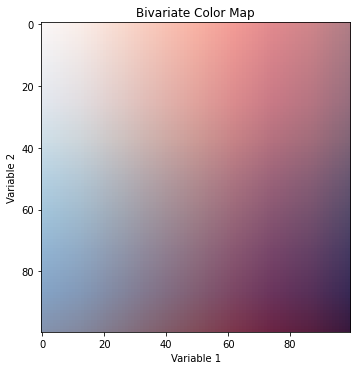

In [120]:
def colorFromBivariateData_plot(Z1,Z2,cmap1 = plt.cm.Blues, cmap2 = plt.cm.Reds):
    # Rescale values to fit into colormap range (0->255)
    Z1_plot = np.array(255*(Z1-Z1.min())/(Z1.max()-Z1.min()), dtype=np.int)
    Z2_plot = np.array(255*(Z2-Z2.min())/(Z2.max()-Z2.min()), dtype=np.int)

    Z1_color = cmap1(Z1_plot)
    Z2_color = cmap2(Z2_plot)

    # Color for each point
    Z_color = np.sum([Z1_color, Z2_color], axis=0)/2.0

    return Z_color

z1 = np.random.random((50,100))
z2 = np.random.random((50,100))
Z_color = colorFromBivariateData_plot(z1,z2)

xx, yy = np.mgrid[0:100,0:100]
C_map = colorFromBivariateData_plot(xx,yy)

fig = plt.figure(figsize=(10,5))

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(C_map)
ax2.set_title('Bivariate Color Map')
ax2.set_xlabel('Variable 1')
ax2.set_ylabel('Variable 2')

fig.tight_layout()
fig.show()

In [121]:
color_result = colorFromBivariateData(xs,ys)
color_result.shape

(529, 4)
(529, 4)


(529, 3)

In [131]:
xs

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9

In [132]:
ys

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,  0,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,  0,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 19, 20, 21, 22,  0,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,  0,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
       14, 15, 16, 17, 18

(529, 4)
(529, 4)


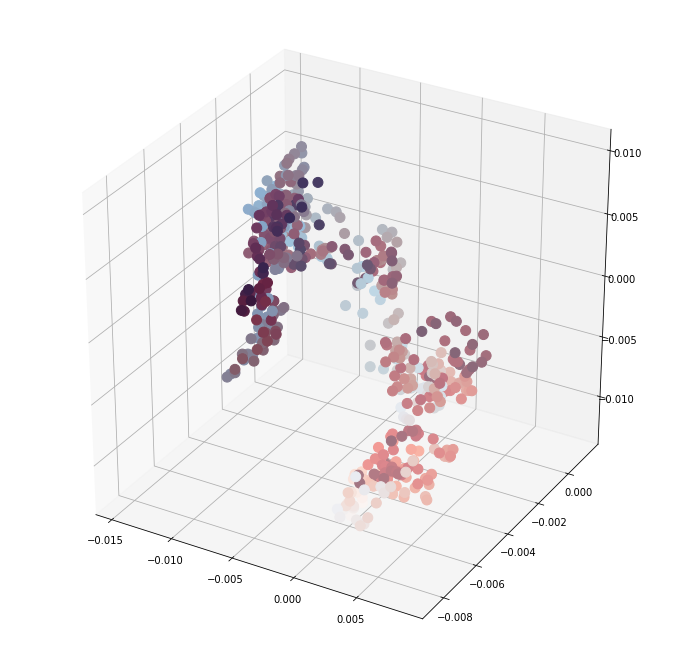

In [122]:
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
data = neuron_cluster1
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromBivariateData(xs,ys),
        s = 100,
        alpha= 1
        ) 

plt.show()

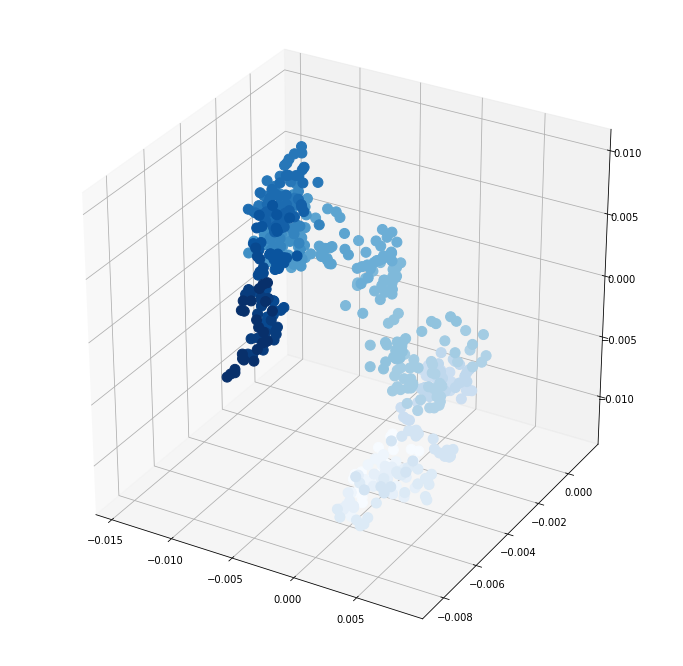

In [125]:
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
data = neuron_cluster1
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromUnivariateData(xs, cmap1 = plt.cm.Blues),
        s = 100,
        alpha= 1
        ) 

plt.show()

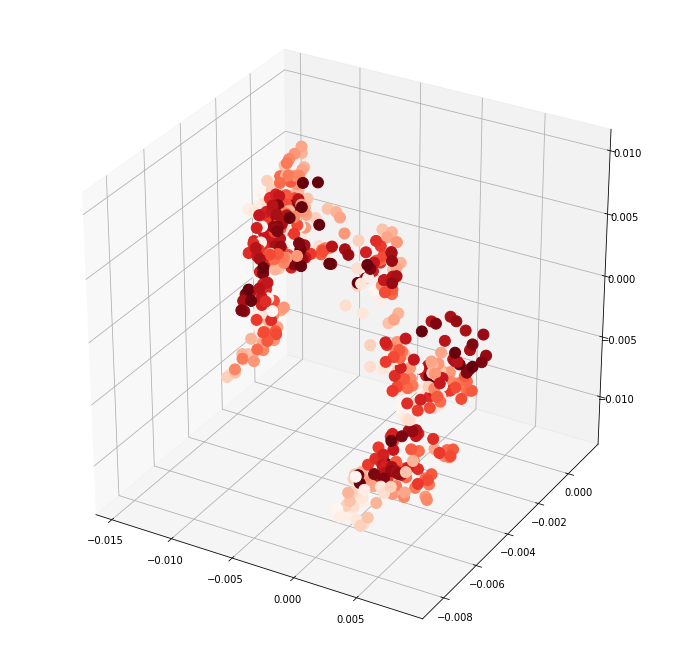

In [135]:
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
data = neuron_cluster1
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromUnivariateData(ys, cmap1 = plt.cm.Reds),
        s = 120,
        alpha= 1
        ) 

plt.show()

In [96]:
neuron_cluster2 = neuron_output_highest_with_shifts_projected[529:529 * 2]
neuron_label2 = neuron_labels[529:529 * 2]

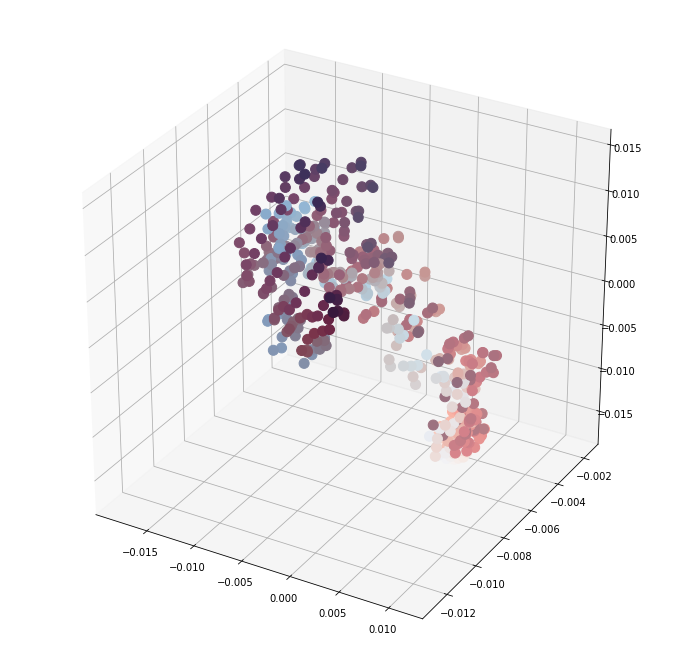

In [130]:
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(projection='3d')
data = neuron_cluster2
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromBivariateData(xs,ys),
        s = 100,
        alpha= 1
        )

plt.show()

(-0.2, 4.2, -0.2, 4.2)

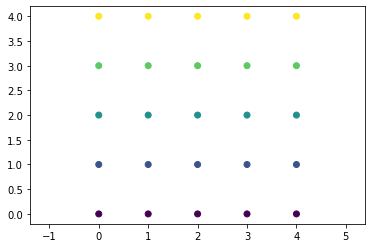

In [ ]:
import numpy as np
h,v = np.meshgrid(range(5),range(5))
n_pos_i = 3
n_pos_j = 2
n_h = h[3,2]
n_v = v[3,2]
import matplotlib.pyplot as plt
X = np.stack([h.ravel()[:,None], v.ravel()[:,None]],axis=1)
plt.scatter(X[:,0],X[:,1],c=v.ravel()); plt.axis('equal')

#alternative: compute colors directly before scatter plot

# Epoch 5:

In [ ]:
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_Model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            print('Time:',time_taken)
            running_loss = 0.0

print('Finished Training of AlexNet: Epoch 5')

[1,  2000] loss: 1.139
Time: 40.31503462791443
[1,  4000] loss: 1.078
Time: 80.8320746421814
[1,  6000] loss: 1.004
Time: 121.8362820148468
[1,  8000] loss: 0.966
Time: 163.5357801914215
[1, 10000] loss: 0.933
Time: 203.87078332901
[1, 12000] loss: 0.888
Time: 243.97469472885132
[2,  2000] loss: 0.763
Time: 40.4606294631958
[2,  4000] loss: 0.742
Time: 80.70401954650879
[2,  6000] loss: 0.739
Time: 121.01034617424011
[2,  8000] loss: 0.702
Time: 161.6569221019745
[2, 10000] loss: 0.688
Time: 202.624351978302
[2, 12000] loss: 0.705
Time: 242.90839767456055
[3,  2000] loss: 0.500
Time: 40.55217123031616
[3,  4000] loss: 0.535
Time: 80.83761715888977
[3,  6000] loss: 0.536
Time: 121.54922723770142
[3,  8000] loss: 0.526
Time: 171.9248766899109
[3, 10000] loss: 0.549
Time: 212.49245715141296
[3, 12000] loss: 0.524
Time: 253.56318831443787
[4,  2000] loss: 0.338
Time: 41.093953371047974
[4,  4000] loss: 0.341
Time: 81.82284450531006
[4,  6000] loss: 0.379
Time: 122.6521430015564
[4,  8000] 

In [ ]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels = show_stimuli(['conv_layer1'], images_selected_classes, shifts = True)
data = np.transpose(neuron_output_highest_with_shifts, (2, 0, 1))
mdic = {"neuron_output_3D": data}
savemat("neuron_output_3D_epoch5.mat", mdic)

In [ ]:
from scipy.io import loadmat 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
F = loadmat('factors_opt_nonneg_3D_conv1_epoch5.mat')['F']
pca = PCA(10)
neuron_output_highest_with_shifts_projected =  pca.fit_transform(F)
neuron_output_highest_with_shifts_projected.shape

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_output_highest_with_shifts_projected

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_labels == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            #color=vertical_values,#(horizontal_values)
            #colorscale='Viridis',#https://plotly.com/python/line-and-scatter/#scatter-with-a-color-dimension
            opacity=1,
            #showscale= False,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 529
1 529
2 529
3 529
4 529
5 529
6 529
7 529
8 529
9 529


# Epoch 10:

In [ ]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_Model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            print('Time:',time_taken)
            running_loss = 0.0

print('Finished Training of AlexNet: Epoch 10')

[1,  2000] loss: 0.199
Time: 40.36648988723755
[1,  4000] loss: 0.224
Time: 79.8635003566742
[1,  6000] loss: 0.257
Time: 119.91458821296692
[1,  8000] loss: 0.267
Time: 159.73274397850037
[1, 10000] loss: 0.282
Time: 200.95238852500916
[1, 12000] loss: 0.274
Time: 241.02670192718506
[2,  2000] loss: 0.124
Time: 40.241389989852905
[2,  4000] loss: 0.155
Time: 80.42709589004517
[2,  6000] loss: 0.182
Time: 120.14391756057739
[2,  8000] loss: 0.180
Time: 159.73434162139893
[2, 10000] loss: 0.190
Time: 199.46029424667358
[2, 12000] loss: 0.204
Time: 239.17746567726135
[3,  2000] loss: 0.109
Time: 39.752939224243164
[3,  4000] loss: 0.113
Time: 79.39789772033691
[3,  6000] loss: 0.119
Time: 119.27195763587952
[3,  8000] loss: 0.137
Time: 159.08003211021423
[3, 10000] loss: 0.164
Time: 198.9999086856842
[3, 12000] loss: 0.156
Time: 238.66402411460876
[4,  2000] loss: 0.069
Time: 39.797585010528564
[4,  4000] loss: 0.087
Time: 79.79801964759827
[4,  6000] loss: 0.097
Time: 119.35665917396545

In [ ]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels = show_stimuli(['conv_layer1'], images_selected_classes, shifts = True)
data = np.transpose(neuron_output_highest_with_shifts, (2, 0, 1))
mdic = {"neuron_output_3D": data}
savemat("neuron_output_3D_epoch10.mat", mdic)

In [ ]:
from scipy.io import loadmat 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
F = loadmat('factors_opt_nonneg_3D_conv1_epoch10.mat')['F']
pca = PCA(10)
neuron_output_highest_with_shifts_projected =  pca.fit_transform(F)
neuron_output_highest_with_shifts_projected.shape

(5290, 10)

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_output_highest_with_shifts_projected

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_labels == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 529
1 529
2 529
3 529
4 529
5 529
6 529
7 529
8 529
9 529


# Epoch 15:

In [ ]:
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_Model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            print('Time:',time_taken)
            running_loss = 0.0

print('Finished Training of AlexNet: Epoch 15')

[1,  2000] loss: 0.041
Time: 43.72062802314758
[1,  4000] loss: 0.046
Time: 83.14854788780212
[1,  6000] loss: 0.049
Time: 122.87277340888977
[1,  8000] loss: 0.039
Time: 162.31593561172485
[1, 10000] loss: 0.072
Time: 202.4207422733307
[1, 12000] loss: 0.059
Time: 242.61818766593933
[2,  2000] loss: 0.021
Time: 40.6830370426178
[2,  4000] loss: 0.039
Time: 80.18149209022522
[2,  6000] loss: 0.032
Time: 119.70345759391785
[2,  8000] loss: 0.041
Time: 159.20094919204712
[2, 10000] loss: 0.041
Time: 198.87737798690796
[2, 12000] loss: 0.065
Time: 238.43901777267456
[3,  2000] loss: 0.034
Time: 42.04613375663757
[3,  4000] loss: 0.026
Time: 82.408038854599
[3,  6000] loss: 0.024
Time: 122.58976793289185
[3,  8000] loss: 0.051
Time: 162.13545513153076
[3, 10000] loss: 0.045
Time: 202.40321326255798
[3, 12000] loss: 0.034
Time: 241.6814467906952
Finished Training of AlexNet: Epoch 15


In [ ]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels = show_stimuli(['conv_layer1'], images_selected_classes, shifts = True)
data = np.transpose(neuron_output_highest_with_shifts, (2, 0, 1))
mdic = {"neuron_output_3D": data}
savemat("neuron_output_3D_epoch15.mat", mdic)

In [ ]:
from scipy.io import loadmat 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
F = loadmat('factors_opt_nonneg_3D_conv1_epoch15.mat')['F']
pca = PCA(10)
neuron_output_highest_with_shifts_projected =  pca.fit_transform(F)
neuron_output_highest_with_shifts_projected.shape

(5290, 10)

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_output_highest_with_shifts_projected

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_labels == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 529
1 529
2 529
3 529
4 529
5 529
6 529
7 529
8 529
9 529


# Epoch 20:

In [ ]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_Model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            print('Time:',time_taken)
            running_loss = 0.0

print('Finished Training of AlexNet: Epoch 20')

[1,  2000] loss: 0.030
Time: 39.865222454071045
[1,  4000] loss: 0.021
Time: 79.90001678466797
[1,  6000] loss: 0.031
Time: 120.00790762901306
[1,  8000] loss: 0.019
Time: 159.22374153137207
[1, 10000] loss: 0.043
Time: 200.90038800239563
[1, 12000] loss: 0.043
Time: 243.47038102149963
[2,  2000] loss: 0.027
Time: 39.484355449676514
[2,  4000] loss: 0.019
Time: 80.00254273414612
[2,  6000] loss: 0.025
Time: 119.88675045967102
[2,  8000] loss: 0.040
Time: 159.25482892990112
[2, 10000] loss: 0.036
Time: 199.16366052627563
[2, 12000] loss: 0.042
Time: 238.2889211177826
[3,  2000] loss: 0.024
Time: 39.77900719642639
[3,  4000] loss: 0.028
Time: 78.9079577922821
[3,  6000] loss: 0.021
Time: 117.73241019248962
[3,  8000] loss: 0.018
Time: 156.58984684944153
[3, 10000] loss: 0.021
Time: 195.49601697921753
[3, 12000] loss: 0.036
Time: 234.65127110481262
[4,  2000] loss: 0.034
Time: 39.48714089393616
[4,  4000] loss: 0.032
Time: 79.03998351097107
[4,  6000] loss: 0.019
Time: 118.52274894714355


In [ ]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels = show_stimuli(['conv_layer1'], images_selected_classes, shifts = True)
data = np.transpose(neuron_output_highest_with_shifts, (2, 0, 1))
mdic = {"neuron_output_3D": data}
savemat("neuron_output_3D_epoch20.mat", mdic)

In [ ]:
from scipy.io import loadmat 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
F = loadmat('factors_opt_nonneg_3D_conv1_epoch20.mat')['F']
pca = PCA(10)
neuron_output_highest_with_shifts_projected =  pca.fit_transform(F)
neuron_output_highest_with_shifts_projected.shape

(5290, 10)

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_output_highest_with_shifts_projected

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_labels == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 529
1 529
2 529
3 529
4 529
5 529
6 529
7 529
8 529
9 529


# Epoch 25:

In [ ]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_Model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            print('Time:',time_taken)
            running_loss = 0.0

print('Finished Training of AlexNet: Epoch 25')

[1,  2000] loss: 0.017
Time: 49.760414361953735
[1,  4000] loss: 0.018
Time: 89.63668513298035
[1,  6000] loss: 0.016
Time: 129.02608585357666
[1,  8000] loss: 0.021
Time: 168.94069910049438
[1, 10000] loss: 0.020
Time: 208.40851950645447
[1, 12000] loss: 0.018
Time: 248.2285304069519
[2,  2000] loss: 0.012
Time: 39.72936773300171
[2,  4000] loss: 0.013
Time: 79.01610517501831
[2,  6000] loss: 0.022
Time: 118.48379635810852
[2,  8000] loss: 0.029
Time: 157.94817399978638
[2, 10000] loss: 0.047
Time: 198.00206303596497
[2, 12000] loss: 0.014
Time: 238.13546299934387
[3,  2000] loss: 0.011
Time: 39.38021397590637
[3,  4000] loss: 0.012
Time: 78.92299437522888
[3,  6000] loss: 0.010
Time: 118.20717406272888
[3,  8000] loss: 0.014
Time: 157.34929180145264
[3, 10000] loss: 0.022
Time: 196.67537307739258
[3, 12000] loss: 0.030
Time: 235.95967388153076
[4,  2000] loss: 0.007
Time: 39.81028413772583
[4,  4000] loss: 0.010
Time: 78.97323298454285
[4,  6000] loss: 0.014
Time: 118.4112458229065
[

In [ ]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels = show_stimuli(['conv_layer1'], images_selected_classes, shifts = True)
data = np.transpose(neuron_output_highest_with_shifts, (2, 0, 1))
mdic = {"neuron_output_3D": data}
savemat("neuron_output_3D_epoch25.mat", mdic)

In [ ]:
from scipy.io import loadmat 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
F = loadmat('factors_opt_nonneg_3D_conv1_epoch25.mat')['F']
pca = PCA(10)
neuron_output_highest_with_shifts_projected =  pca.fit_transform(F)
neuron_output_highest_with_shifts_projected.shape

(5290, 10)

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_output_highest_with_shifts_projected

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_labels == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 529
1 529
2 529
3 529
4 529
5 529
6 529
7 529
8 529
9 529


# Appendix:

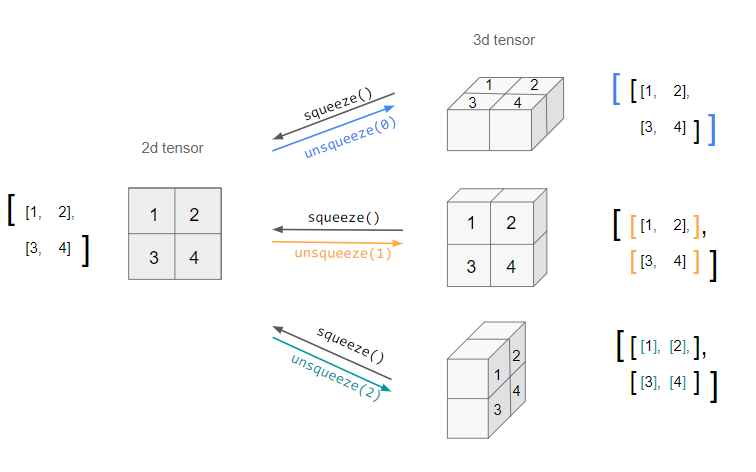

resizing imagenet: 

https://discuss.pytorch.org/t/how-do-i-resize-imagenet-image-to-224-x-224/66979

https://pytorch.org/vision/stable/_modules/torchvision/datasets/imagenet.html#ImageNet